# Imports

In [16]:
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Read Image

In [17]:
def readImage(image_path):
    img = Image.open(image_path).convert("L")
    return np.array(img)


# Double Integral and Local Sum

In [18]:
def RowIntegral(array):
    newArray = np.zeros((len(array), len(array[0])), dtype=np.int64)
    for i in range(len(array)):
        for j in range(len(array[i])):
            if(j == 0):
                newArray[i][j] = array[i][j]
            else:
                newArray[i][j] = newArray[i][j-1] + array[i][j]
    return newArray
def ColumnIntegral(array):
    newArray = np.zeros((len(array), len(array[0])), dtype=np.int64)
    for i in range(len(array)):
        for j in range(len(array[i])):
            if(i == 0):
                newArray[i][j] = array[i][j]
            else:
                newArray[i][j] = newArray[i-1][j] + array[i][j]
    return newArray

def doubleIntegral(array):
    return ColumnIntegral(RowIntegral(array))

def LocalSum(array, x1, y1, x2, y2):
    s = array[x2, y2]
    if x1 > 0: s -= array[x1-1, y2]
    if y1 > 0: s -= array[x2, y1-1]
    if x1 > 0 and y1 > 0: s += array[x1-1, y1-1]
    return s

# Detect Eye

In [19]:
def to_abs(i, j, columns, rows):
    return int(round(i + rows)), int(round(j + columns))

def DetectEye(I, n):
    H, W = I.shape
    m = int(round(0.15 * n))
    P = {
        'P1': (-0.5*n, -0.5*m), 
        'P2': (-0.05*n, 0), 
        'P3': (-0.5*n, 0), 
        'P4': (-0.05*n, 0.5*m), 
        'P5': ( 0.05*n, -0.5*m), 
        'P6': ( 0.5*n, 0), 
        'P7': ( 0.05*n, 0),
        'P8': ( 0.5*n, 0.5*m),
        'P9': (-0.325*n, 0.833*m),
        'P10': (-0.225*n, 2*m), 
        'P11': (-0.1*n, 0.833*m), 
        'P12': ( 0.1*n, 2*m), 
        'P13': ( 0.225*n, 0.833*m),
        'P14': ( 0.325*n, 2*m),
    }
    margin_top    = round(0.5 * m)
    margin_bottom = round(2.0 * m)
    margin_left   = margin_right = round(0.5 * n)
    best_score, best_pos = -1e18, (0, 0)
    for i in range(margin_top, H - margin_bottom):
        for j in range(margin_left, W - margin_right):
            def rs(a,b):
                row1, col1 = to_abs(i, j, *P[a]); 
                row2, col2 = to_abs(i, j, *P[b])
                top, bottom = sorted([row1, row2]); 
                left, right = sorted([col1, col2])
                return LocalSum(I, top, left, bottom, right)


            LS1 = rs('P1','P2');  LS2 = rs('P5','P6')
            LS3 = rs('P3','P4');  LS4 = rs('P7','P8')
            LS5 = rs('P9','P10'); LS6 = rs('P11','P12'); LS7 = rs('P13','P14')
            score = (LS1 + LS2 + LS6) - (LS3 + LS4 + LS5 + LS7)
            if score > best_score:
                best_score, best_pos = score, (i, j)
    return best_pos

# Extract Eyes

In [20]:
def ExtractDetectedEye(img_gray, center_rc, n):
    i, j = center_rc
    m = int(round(0.15 * n))
    top    = int(round(i - 0.5*m))
    bottom = int(round(i + 2.0*m))
    left   = int(round(j - 0.5*n))
    right  = int(round(j + 0.5*n))
    H, W = img_gray.shape
    top = max(0, top)
    left = max(0, left)
    bottom = min(H, bottom)
    right = min(W, right)
    out = np.zeros_like(img_gray)
    out[top:bottom+1, left:right+1] = img_gray[top:bottom+1, left:right+1]
    return out, (top, left, bottom, right)


# Results

## Test 1

Center: (219, 566) BBox (top,left,bottom,right): (194, 401, 319, 731)


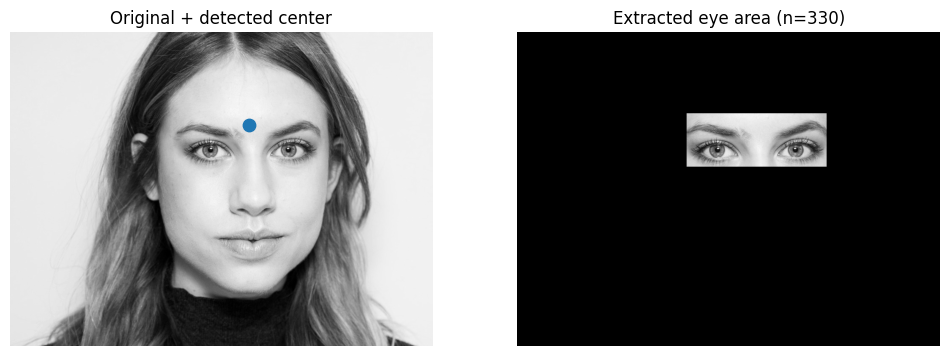

In [21]:
img_path = "/kaggle/input/imagescv/Image 1.jpeg"
n = 330
img = readImage(img_path)

I = doubleIntegral(img)
center = DetectEye(I, n)

masked, bbox = ExtractDetectedEye(img, center, n)
print("Center:", center, "BBox (top,left,bottom,right):", bbox)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img, cmap='gray'); axes[0].scatter([center[1]], [center[0]], s=80)
axes[0].set_title("Original + detected center"); axes[0].axis('off')
axes[1].imshow(masked, cmap='gray'); axes[1].set_title(f"Extracted eye area (n={n})"); axes[1].axis('off')
plt.show()

## Test 2

Center: (241, 524) BBox (top,left,bottom,right): (222, 399, 317, 649)


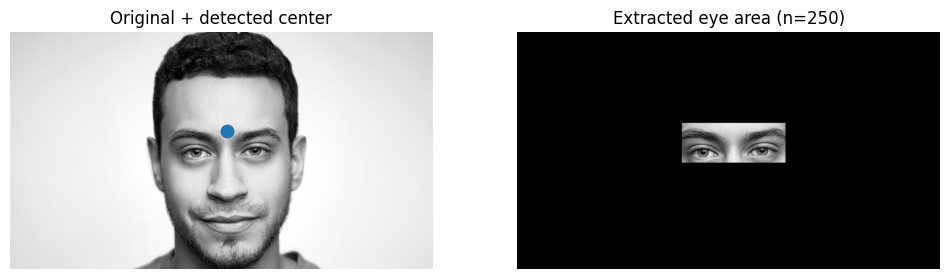

In [22]:
img_path = "/kaggle/input/imagescv/Image 2.jpeg"
n = 250
img = readImage(img_path)

I = doubleIntegral(img)
center = DetectEye(I, n)

masked, bbox = ExtractDetectedEye(img, center, n)
print("Center:", center, "BBox (top,left,bottom,right):", bbox)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img, cmap='gray'); axes[0].scatter([center[1]], [center[0]], s=80)
axes[0].set_title("Original + detected center"); axes[0].axis('off')
axes[1].imshow(masked, cmap='gray'); axes[1].set_title(f"Extracted eye area (n={n})"); axes[1].axis('off')
plt.show()

## Test 3

Center: (89, 201) BBox (top,left,bottom,right): (78, 126, 133, 276)


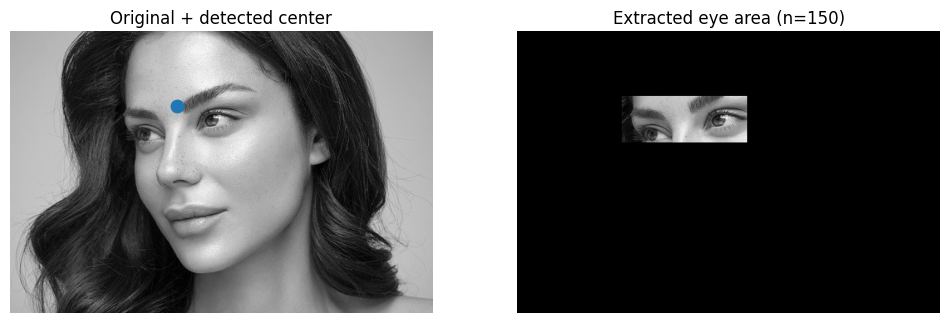

In [23]:
img_path = "/kaggle/input/imagescv/Image 3.jpeg"
n = 150
img = readImage(img_path)

I = doubleIntegral(img)
center = DetectEye(I, n)

masked, bbox = ExtractDetectedEye(img, center, n)
print("Center:", center, "BBox (top,left,bottom,right):", bbox)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img, cmap='gray'); axes[0].scatter([center[1]], [center[0]], s=80)
axes[0].set_title("Original + detected center"); axes[0].axis('off')
axes[1].imshow(masked, cmap='gray'); axes[1].set_title(f"Extracted eye area (n={n})"); axes[1].axis('off')
plt.show()

# Extra Images

## Test 4

Center: (137, 257) BBox (top,left,bottom,right): (126, 182, 181, 332)


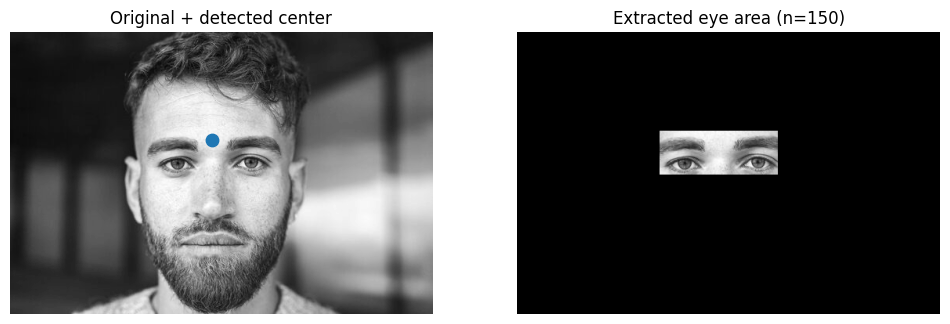

In [24]:
img_path = "/kaggle/input/imagescv/Image 4.jpeg"
n = 150
img = readImage(img_path)

I = doubleIntegral(img)
center = DetectEye(I, n)

masked, bbox = ExtractDetectedEye(img, center, n)
print("Center:", center, "BBox (top,left,bottom,right):", bbox)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img, cmap='gray'); axes[0].scatter([center[1]], [center[0]], s=80)
axes[0].set_title("Original + detected center"); axes[0].axis('off')
axes[1].imshow(masked, cmap='gray'); axes[1].set_title(f"Extracted eye area (n={n})"); axes[1].axis('off')
plt.show()

## Test 5

Center: (100, 306) BBox (top,left,bottom,right): (93, 261, 128, 351)


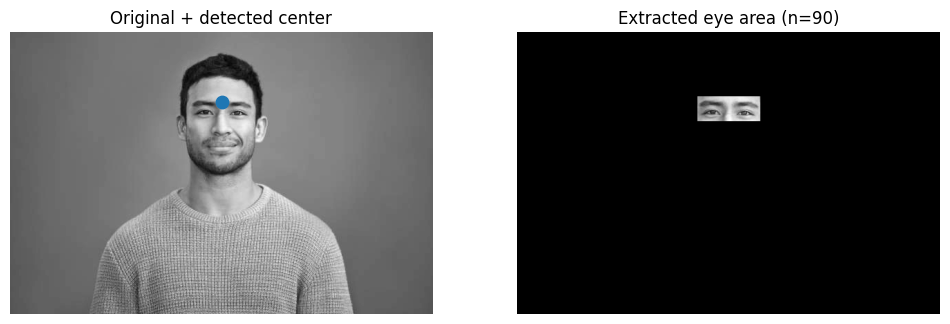

In [25]:
img_path = "/kaggle/input/imagescv/Image 5.jpeg"
n = 90
img = readImage(img_path)

I = doubleIntegral(img)
center = DetectEye(I, n)

masked, bbox = ExtractDetectedEye(img, center, n)
print("Center:", center, "BBox (top,left,bottom,right):", bbox)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img, cmap='gray'); axes[0].scatter([center[1]], [center[0]], s=80)
axes[0].set_title("Original + detected center"); axes[0].axis('off')
axes[1].imshow(masked, cmap='gray'); axes[1].set_title(f"Extracted eye area (n={n})"); axes[1].axis('off')
plt.show()

## Test 6

Center: (200, 360) BBox (top,left,bottom,right): (188, 280, 248, 440)


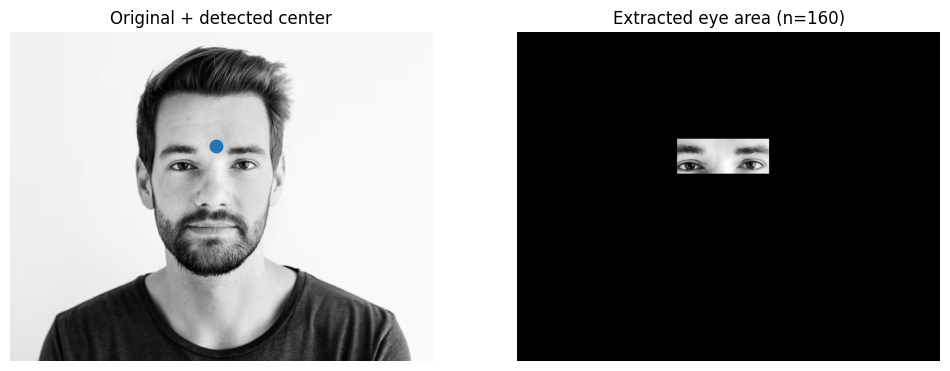

In [26]:
img_path = "/kaggle/input/imagescv/Image 6.jpeg"
n = 160
img = readImage(img_path)

I = doubleIntegral(img)
center = DetectEye(I, n)

masked, bbox = ExtractDetectedEye(img, center, n)
print("Center:", center, "BBox (top,left,bottom,right):", bbox)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img, cmap='gray'); axes[0].scatter([center[1]], [center[0]], s=80)
axes[0].set_title("Original + detected center"); axes[0].axis('off')
axes[1].imshow(masked, cmap='gray'); axes[1].set_title(f"Extracted eye area (n={n})"); axes[1].axis('off')
plt.show()

## Test 7

Center: (161, 372) BBox (top,left,bottom,right): (148, 287, 213, 457)


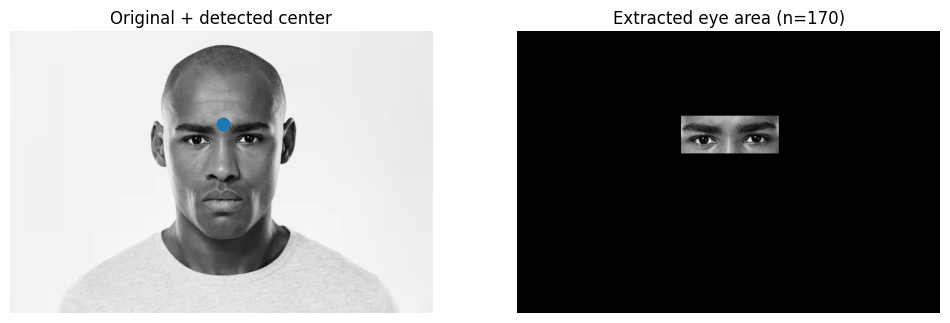

In [27]:
img_path = "/kaggle/input/imagescv/Image 7.jpeg"
n = 170
img = readImage(img_path)

I = doubleIntegral(img)
center = DetectEye(I, n)

masked, bbox = ExtractDetectedEye(img, center, n)
print("Center:", center, "BBox (top,left,bottom,right):", bbox)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img, cmap='gray'); axes[0].scatter([center[1]], [center[0]], s=80)
axes[0].set_title("Original + detected center"); axes[0].axis('off')
axes[1].imshow(masked, cmap='gray'); axes[1].set_title(f"Extracted eye area (n={n})"); axes[1].axis('off')
plt.show()

## Test 8

Center: (63, 419) BBox (top,left,bottom,right): (46, 309, 129, 529)


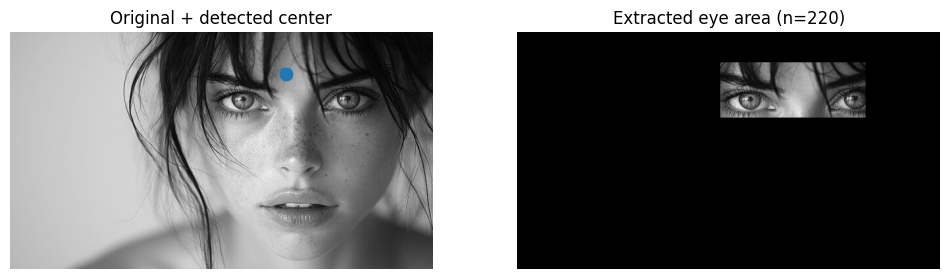

In [29]:
img_path = "/kaggle/input/imagescv/image 8.jpeg"
n = 220
img = readImage(img_path)

I = doubleIntegral(img)
center = DetectEye(I, n)

masked, bbox = ExtractDetectedEye(img, center, n)
print("Center:", center, "BBox (top,left,bottom,right):", bbox)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img, cmap='gray'); axes[0].scatter([center[1]], [center[0]], s=80)
axes[0].set_title("Original + detected center"); axes[0].axis('off')
axes[1].imshow(masked, cmap='gray'); axes[1].set_title(f"Extracted eye area (n={n})"); axes[1].axis('off')
plt.show()